We have already learned about [evaluation metrics for classification](../2_classification/2_evaluation_metrics.ipynb). In object detection, we also perform some kind of classification. More specifically, a detector returns a set of bounding boxes with corresponding class labels. As such, the model has classified the image regions that correspond to the bounding boxes.

Just like any classification problem, the label that is assigned to a certain image region can either be correct or incorrect. Let's say the model assigns a certain class label *A* to an image region. Then, there are two options

1. **True positive** (TP) of label *A*: the region is predicted to have label *A* and indeed has label *A*
2. **False positive** (FP) of label *A*: the region is predicted to have label *A*, but *does not* have label *A*

Of course, there will be many image regions that **do not receive a certain label** from the detector. Let's say the model did not assign label *A* to a certain image region. Then, again, there are two possibilities:

1. **True negative** (TN) of label *A*: the region is predicted to *not* have label *A* and indeed does not have label *A*
2. **False negative** (FN) of label *A*: the region is predicted to *not* have label *A*, but *does* have label *A*

To evaluate the predictions, we compare them with the **ground-truth bounding boxes**. However, **predictions will almost never exactly overlap** with a ground-truth bounding box. Of course, this does not mean that all predicted bounding boxes are *bad* and should be counted as false positives. Instead, we use the **Intersection over Union** (IoU) to define when a predicted bounding box is a TP, FP or FN for a certain class.

We can choose this IoU ourselves. Let's say we give it a value $\alpha$. Then a TP, FP and FN of a class label *A* at this IoU level $\alpha$ is defined as follows:

- **True positive at $\alpha$** ($\text{TP}_\alpha$) of label *A*: the predicted bounding box has label *A* and has an IoU $\ge \alpha$ with a ground truth bounding box that has label *A*
- **False positive at $\alpha$** ($\text{FP}_\alpha$) of label *A*: the predicted bounding box has label *A*, but does not have an IoU $\ge \alpha$ with a ground truth bounding box that has label *A*
- **False negative at $\alpha$** ($\text{FN}_\alpha$) of label *A*: a ground truth bounding box that has label *A*, without there being any prediction of label *A* that has an IoU $\ge \alpha$ with it

Defining *True negatives at $\alpha$* is not necessary, since we do not use it to calculate precision and recall. This makes sense, because the amount of regions in an image that *do not* belong to a certain class is huge and rather uninformative.

In [1]:
import math
from itertools import product


def get_tiled_regions(region_size, n_regions_per_dim):
    """
    Return the (x1, y1, x2, y2) coordinates of a number of tiled regions of the given size.
    
    If num_regions is not a square, the next square number of regions will be returned.
    """
    region_starts = np.array(range(0, n_regions_per_dim * region_size,
                                   region_size))
    region_ends = region_starts + region_size

    region_x1y1 = np.array(list(product(region_starts, region_starts)))
    region_x2y2 = np.array(list(product(region_ends, region_ends)))

    return np.hstack([region_x1y1, region_x2y2])

In [2]:
from random import randint, uniform


def get_random_box_in_region(region, min_rel_size=0.3,
                             min_ar=0.5, max_ar=2.0):
    region_width = region[2] - region[0]
    region_height = region[3] - region[1]

    w = randint(int(region_width*min_rel_size), region_width)
    ar = uniform(min_ar, max_ar)
    h = min(int(w/ar), region_height - 1)

    x1 = randint(region[0], region[2] - w)
    y1 = randint(region[1], region[3] - h)
    x2 = min(x1 + w, region[2])
    y2 = min(y1 + h, region[3])

    return np.array([
        x1, y1, x2, y2
    ])

In [3]:
import math
from random import sample, randint, uniform

import numpy as np
from PIL import Image, ImageDraw


def generate_pseudo_boxes(
    img_size=500,
    num_boxes=25,
    n_labels=3,
):
    n_boxes_per_dim = math.ceil(math.sqrt(num_boxes))
    region_size = img_size // n_boxes_per_dim

    regions = get_tiled_regions(region_size, n_boxes_per_dim)
    regions = np.array(sample(list(regions), num_boxes))

    boxes = np.vstack([
        get_random_box_in_region(region, min_ar=1.0, max_ar=1.0)
        for region in regions
    ])

    labels = np.random.randint(0, n_labels, num_boxes)
    
    return boxes, labels

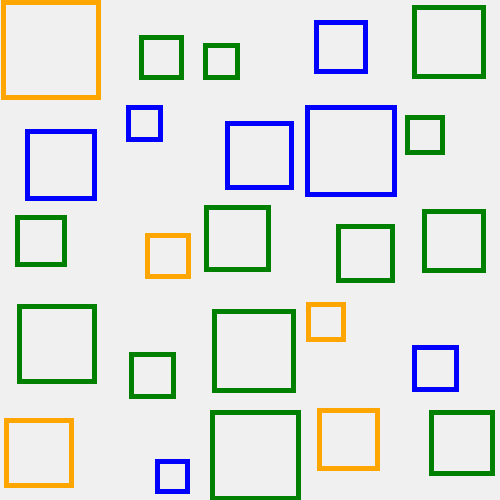

In [4]:
img_size = 500
num_boxes = 25
n_labels = 3

boxes, labels = generate_pseudo_boxes(img_size, num_boxes, n_labels)

img = np.ones((img_size, img_size, 3), np.uint8)*240

im = Image.fromarray(img)


label_colors = ['orange', 'blue', 'green']


draw = ImageDraw.Draw(im)

for box, label in zip(boxes, labels):
    color = label_colors[label]
    draw.rectangle(tuple(box), width=5, outline=color)

im

Now that we have defined how we to calculate $\text{TP}_\alpha$, $\text{FP}_\alpha$ and $\text{FN}_\alpha$ for a certain class label at a give IoU level $\alpha$, we can calculate the precision and recall at that IoU level:

$$\text{Precision}_\alpha = \frac{\text{TP}_\alpha}{\text{TP}_\alpha + \text{FP}_\alpha}$$

$$\text{Recall}_\alpha = \frac{\text{TP}_\alpha}{\text{TP}_\alpha + \text{FN}_\alpha}$$

The detector will return a score that indicates how convinced it is of its prediction. As with classification, we can threshold this score to improve our precision. When we plot the precision and recall for all possible threshold values, we obtain a PR-curve for the chosen IoU level.

To summarize the PR-curve at the chosen IoU level, we can again compute the **average precision**, which is the integral of the PR-curve.

$$
\text{AP}_\alpha = \sum_{t} P_\alpha(t)\cdot (R_{\alpha}(t) - R_\alpha(t-1))
$$

with $P_\alpha(t)$ and $R_\alpha(t)$ the precision, resp. recall, at threshold $t$ and IoU level $\alpha$ ($R_\alpha(0)$ is defined as 1).

## Mean Average Precision

Up until now, we have calculated each metric *for a single class*. The **mean Average Precision at $\alpha$** ($\text{mAP}_\alpha$) is the mean of the $\text{AP}_\alpha$ of each class in the dataset.

## COCO AP

We can calculate $\text{mAP}_\alpha$ for different values of $\alpha$ (the IoU level). In the literature, **COCO AP** is frequently used as a metric. It is computed as the average of $\text{mAP}_{0.50}$, $\text{mAP}_{0.55}$, $\text{mAP}_{0.60}$, ..., $\text{mAP}_{0.95}$. It is written as $\text{mAP}_{[.5:.05:.95]}$ or $\text{AP}_{\text{COCO}}$ or even just $\text{AP}$.